In [12]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from skimage.feature import hog


## Dataset Class

In [13]:
""
root_dir = "/content/drive/MyDrive/machine learning/project/dataset"
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes = ["hole", "paper", "penMark"]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith(".jpg") or file_name.endswith(".png"):
                    file_path = os.path.join(class_dir, file_name)
                    self.samples.append((file_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


## Dataloader

In [16]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(root_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
len(dataloader)

1500

## Visualize Dataset

Displaying images for class 'hole'...


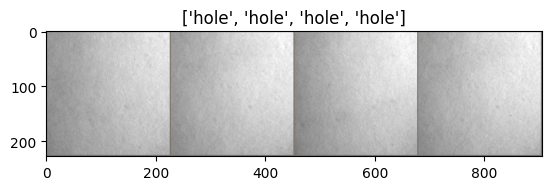

Displaying images for class 'paper'...


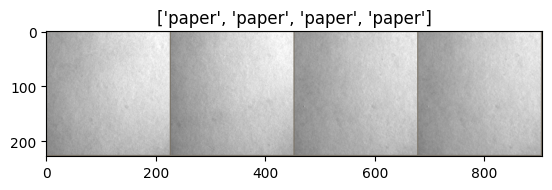

Displaying images for class 'penMark'...


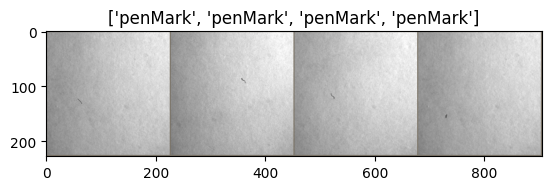

In [17]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Loop over each class in the dataset
for class_idx, class_name in enumerate(dataset.classes):
    print(f"Displaying images for class '{class_name}'...")
    # Get a batch of input data for the current class
    class_samples = [sample for sample in dataset.samples if sample[1] == class_idx]
    class_dataset = torch.utils.data.Subset(dataset, [dataset.samples.index(sample) for sample in class_samples])
    class_dataloader = torch.utils.data.DataLoader(class_dataset, batch_size=4, shuffle=True)
    # Get a batch of input data for the current class
    inputs, classes = next(iter(class_dataloader))
    # Make a grid from the input batch
    out = torchvision.utils.make_grid(inputs)
    # Display the grid using the imshow function
    imshow(out, title=[class_name]*len(inputs))

## Feature extraction

### HOG feature extractor

### SIFT features

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Extract HOG features for the dataset
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'channel_axis': -1
}

def extract_hog_features(dataset, window_size=(64, 64)):
    hog_features = []
    labels = []
    
    for image, label in dataset:
        image = cv2.resize(np.array(image.permute(1, 2, 0)), window_size)  # Resize and convert to NumPy array
        hog_feature = hog(image, **hog_params)
        hog_features.append(hog_feature)
        labels.append(label)
    
    return np.array(hog_features), np.array(labels)


# import cv2
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Extract SIFT features for the dataset
# def extract_sift_features(dataset, n_clusters=50, max_keypoints=200):
#     sift = cv2.SIFT_create(nfeatures=max_keypoints)
#     all_descriptors = []
#     image_descriptors = []
#     labels = []

#     for image, label in dataset:
#         image = np.array(image.permute(1, 2, 0))  # Convert from PyTorch tensor to NumPy array
#         _, descriptors = sift.detectAndCompute(image, None)
#         if descriptors is not None:
#             all_descriptors.extend(descriptors)
#             image_descriptors.append(descriptors)
#             labels.append(label)

#     # Create a bag of visual words using KMeans clustering
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(all_descriptors)

#     # Create fixed-size feature vectors for each image using the bag of visual words
#     feature_vectors = []
#     for descriptors in image_descriptors:
#         histogram = np.zeros(n_clusters)
#         cluster_assignments = kmeans.predict(descriptors)
#         for assignment in cluster_assignments:
#             histogram[assignment] += 1
#         feature_vectors.append(histogram)

#     return np.array(feature_vectors), np.array(labels)

# # Extract SIFT features
# sift_features, labels = extract_sift_features(dataset)

# # Split dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(sift_features, labels, test_size=0.2, random_state=42)





# Extract HOG features
hog_features, labels = extract_hog_features(dataset)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)





In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
def run_experiments(X_train, y_train, kernels, hyperparameters):
    param_grid = {'kernel': kernels, **hyperparameters}
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

kernels = ['linear', 'rbf', 'poly']
hyperparameters = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'degree': [2, 3, 4, 5]  # only applicable for 'poly' kernel
}

best_params, best_score, best_classifier = run_experiments(X_train, y_train, kernels, hyperparameters)

print(f"Best parameters: {best_params}")
print(f"Best accuracy (cross-validation): {best_score * 100:.2f}%")

# Test the best classifier on the test set
y_pred = best_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Detailed classification report
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=dataset.classes))

Best parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy (cross-validation): 39.50%
Accuracy on test set: 39.00%
Classification report:
              precision    recall  f1-score   support

        hole       0.31      0.30      0.31       100
       paper       0.37      0.52      0.44        88
     penMark       0.51      0.37      0.42       112

    accuracy                           0.39       300
   macro avg       0.40      0.40      0.39       300
weighted avg       0.40      0.39      0.39       300



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

def run_classifier_experiments(X_train, y_train, X_test, y_test, classifiers):
    results = []

    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append((clf_name, accuracy))
        print("Classification report: ", clf_name)
        print(classification_report(y_test, y_pred, target_names=dataset.classes))

    return results

classifiers = {
    'SVM': SVC(C=1, kernel='rbf', gamma='scale', degree=2),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

results = run_classifier_experiments(X_train, y_train, X_test, y_test, classifiers)

for clf_name, accuracy in results:
    print(f"{clf_name} accuracy: {accuracy * 100:.2f}%")


NameError: ignored